<a href="https://colab.research.google.com/github/WelfLowe/ML4developers/blob/main/6_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# Import useful libraries
from sklearn.datasets import make_classification 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X = iris.data
y = iris.target
X.shape

(150, 4)

In [78]:
# Create a class for the Softmax linear classifier
class Softmax(object):    

  def __init__(self):
    self.W = None
    self.b = None
    self.history = []
    
  def get_loss_grads(self, X, y, reg, n_samples):  
    # Linear mapping scores
    scores = np.dot(X, self.W)+self.b

    # Normalize the scores beforehand with max as zero to avoid 
    # computational problems with the exponential
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))

    # Softmax activation
    probs = exp_scores/np.sum(exp_scores, axis=1, keepdims=True)

    # Logloss of the correct class for each of our samples
    correct_logprobs = -np.log(probs[np.arange(n_samples), y])

    # Compute the average loss
    loss = np.sum(correct_logprobs)/n_samples

    # Add regularization using the L2 norm
    reg_loss = 0.5*reg*np.sum(self.W*self.W)
    loss += reg_loss
    
    # Gradient of the loss with respect to scores
    dscores = probs.copy()

    # Substract 1 from the scores of the correct class
    dscores[np.arange(n_samples),y] -= 1
    dscores /= n_samples

    # Gradient of the loss with respect to weights
    dW = X.T.dot(dscores) 

    # Add gradient regularization 
    dW += reg*self.W

    # Gradient of the loss with respect to biases
    db = np.sum(dscores, axis=0, keepdims=True)

    return loss, dW, db


  def train(self, X, y, learning_rate=1e-4, reg=0.5, num_iters=500):
    # Get useful parameters
    n_features, n_samples = X.shape[1], X.shape[0]   
    n_samples = X.shape[0] 
    n_classes = len(np.unique(y))
    
    # Initialize weights from a normal distribution and the biases with zeros
    if (self.W is None) & (self.b is None):
      np.random.seed(2016) # for reproducible results
      self.W = np.random.normal(loc=0.0, scale=1e-4, size=(n_features, n_classes))
      self.b = np.zeros((1, n_classes))
        
    for iter in range(num_iters):
      # Get loss and gradients
      loss, dW, db = self.get_loss_grads(X, y, reg, n_samples)
      
      # update weights and biases
      self.W -= learning_rate*dW
      self.b -= learning_rate*db

      # Compute validation accuracy
      accuracy = self.eval(X,y)
      self.history.append(accuracy)
        
        
  def train_early_stopping(self, X_train, y_train, X_val, y_val, learning_rate=1e-4, reg=0.5, early_stopping_rounds=200):
    # Get useful parameters_train
    n_features, n_samples = X_train.shape[1], X_train.shape[0]   
    n_samples = X_train.shape[0] 
    n_classes = len(np.unique(y))
    
    # Initialize weights from a normal distribution and the biases with zeros
    if (self.W is None) & (self.b is None):
      np.random.seed(2016) # for reproducible results
      self.W = np.random.normal(loc=0.0, scale=1e-4, size=(n_features, n_classes))
      self.b = np.zeros((1, n_classes))

    # Stores best accuracy found 
    best_val_accuracy = -1
    
    # Stores the weights and biases of the best iteration
    best_weights, best_bias = None, None
    
    # Counts the number of no improvements in the accuracy
    no_improvement = 0
    
    # Boolean variable which helps us get out of the while loop
    keep_training = True
        
    while keep_training:
        
      # Get loss and gradients
      loss, dW, db = self.get_loss_grads(X_train, y_train, reg, n_samples)
    
      # update weights and biases
      self.W -= learning_rate*dW
      self.b -= learning_rate*db
              
      # Compute validation accuracy
      val_accuracy = self.eval(X_val,y_val)
      train_accuracy = self.eval(X_train,y_train)

      self.history.append([val_accuracy,train_accuracy])

      if val_accuracy>best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_weights, best_bias = self.W, self.b
        # reset count
        no_improvement = 0
      else:
        no_improvement += 1
        
      if no_improvement == early_stopping_rounds:
        self.W, self.b = best_weights, best_bias
        keep_training = False
      
      
  def predict(self, X):
    y_pred = np.dot(X, self.W)+self.b
    y_pred=np.argmax(y_pred, axis=1)

    return y_pred

  def eval(self, X, y):
    return np.mean(self.predict(X)==y)

In [115]:
def plot_history(history, labels):
  x = range(len(history))
  hist_arr = np.asarray(softmax.history)
  print(hist_arr.shape)
  if hist_arr.ndim==1:
    plt.plot(x, hist_arr, label=labels );
  else:
    i = 0
    for hist_row in hist_arr.transpose():
      plt.plot(x, hist_row, label = labels[i]);
      i += 1 
    
  plt.title("Improvement of accuracy over epochs")
  plt.xlabel("epochs")
  plt.ylabel("accuracy");
  plt.legend();

Accuracy 0.8866666666666667
(500,)


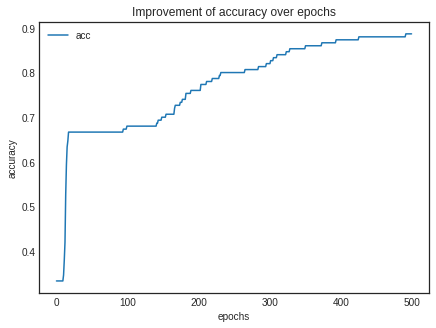

In [109]:
softmax = Softmax()
softmax.train( X, y, learning_rate=1e-2, reg=0.1, num_iters=500)
print('Accuracy', softmax.eval(X, y))
plot_history(softmax.history, 'acc')

Training accuracy 0.95
Validation accuracy 1.0
(1174, 2)


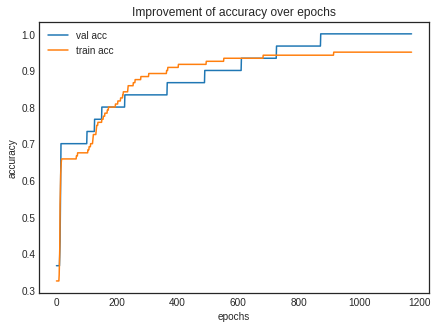

In [116]:
# Split dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) #random_state=2

# Train with early stopping
softmax = Softmax()
softmax.train_early_stopping( X_train, y_train, X_val, y_val, learning_rate=1e-2, reg=0.1, early_stopping_rounds=300)
print('Training accuracy', softmax.eval(X_train, y_train))
print('Validation accuracy', softmax.eval(X_val, y_val))
plot_history(softmax.history, ['val acc', 'train acc'])